# Assignment 6

In this assignment you are asked to train a CNN to classify skin models images into benign and malign.

## Download the dataset

In [0]:
!wget https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/skin-cancer-malignant-vs-benign.zip

--2020-01-17 19:34:48--  https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/skin-cancer-malignant-vs-benign.zip
Resolving mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud (mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud)... 158.177.118.97
Connecting to mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud (mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud)|158.177.118.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340467838 (325M) [application/zip]
Saving to: ‘skin-cancer-malignant-vs-benign.zip’

skin-cancer-maligna 100%[===================>] 324.70M  20.6MB/s    in 17s     

2020-01-17 19:35:12 (18.6 MB/s) - ‘skin-cancer-malignant-vs-benign.zip’ saved [340467838/340467838]



Extract dataset

In [0]:
!unzip skin-cancer-malignant-vs-benign.zip

Archive:  skin-cancer-malignant-vs-benign.zip
  inflating: data/test/benign/1.jpg  
  inflating: data/test/benign/10.jpg  
  inflating: data/test/benign/1003.jpg  
  inflating: data/test/benign/1006.jpg  
  inflating: data/test/benign/1013.jpg  
  inflating: data/test/benign/1018.jpg  
  inflating: data/test/benign/1019.jpg  
  inflating: data/test/benign/1023.jpg  
  inflating: data/test/benign/1025.jpg  
  inflating: data/test/benign/1029.jpg  
  inflating: data/test/benign/1033.jpg  
  inflating: data/test/benign/1034.jpg  
  inflating: data/test/benign/1042.jpg  
  inflating: data/test/benign/1044.jpg  
  inflating: data/test/benign/105.jpg  
  inflating: data/test/benign/1055.jpg  
  inflating: data/test/benign/1061.jpg  
  inflating: data/test/benign/1070.jpg  
  inflating: data/test/benign/1074.jpg  
  inflating: data/test/benign/1077.jpg  
  inflating: data/test/benign/1080.jpg  
  inflating: data/test/benign/1087.jpg  
  inflating: data/test/benign/1088.jpg  
  inflating: data

## 2. Explore the data

In [0]:
import os 

train_path, test_path = 'train', 'test'

classes = os.listdir(train_path)
classes

['malignant', 'benign']

In [0]:
def load_data(PATH): 
  imgs, labels = [], []
  for i, lab in enumerate(classes):
    paths = os.listdir(f'{PATH}/{lab}')
    paths = [p for p in paths if p[-3:] == "jpg"]
    imgs += [f'{PATH}/{lab}/{img}' for img in paths]
    labels += [i]*len(paths)
  return imgs, labels

train_images, train_labels = load_data('train')
test_images, test_labels = load_data('test')

len(train_images), len(train_labels), len(test_images), len(test_labels)

(2637, 2637, 660, 660)

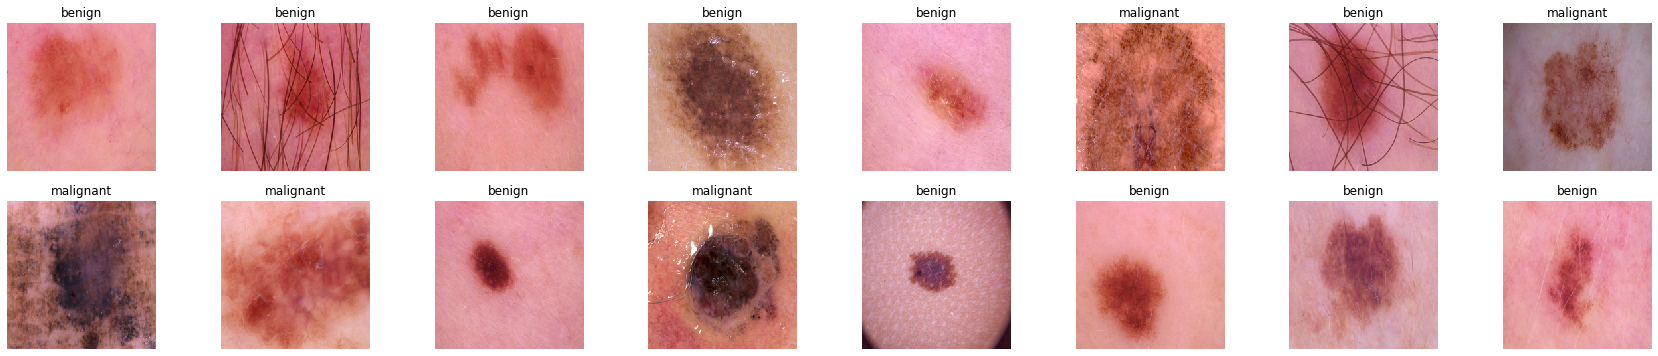

In [0]:
# print some images

import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,8, figsize=(30,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(train_images)-1)
    img = io.imread(train_images[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[train_labels[ix]])
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels)

len(train_imgs), len(val_imgs)

(2109, 528)

## Train a CNN

Define and train a CNN that you think can get good results (for example, something similar to VGG). What is the best performance that you can get ? 

In [0]:
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MyDataset(Dataset):
  def __init__(self, X, y=None, train=True, trans=None):
    self.X = X
    self.y = y
    self.train = train
    self.len = len(X)
    self.trans = trans

  def __len__(self):
    return self.len 

  def __getitem__(self, ix):
    img = io.imread(self.X[ix])
    if self.trans:
      augmented = self.trans(image=img)
      img = augmented["image"]
    # img -> [224, 224, 3]
    img = torch.from_numpy(img / 255.).float().permute(2,0,1)
    # img -> [3, 224, 224]
    if self.train:
      label = self.y[ix]
      return img, label
    return img

class Model():
  def __init__(self, net):
    self.net = net

  def compile(self, loss, optimizer, metrics, scheduler=None):
    self.loss = loss
    self.optimizer = optimizer
    self.metrics = metrics
    self.scheduler=scheduler

  def fit(self, X, y, epochs=100, validation_data=None, batch_size=32, verbose=True, early_stopping=False, trans=None, validation_trans=None):

    dataset = MyDataset(X, y, trans=trans)
    dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
    self.history = {"loss": []}
    for metric in self.metrics:
      self.history[f'{metric.name}'] = []

    if validation_data:
      dataset = MyDataset(validation_data[0], validation_data[1], trans=validation_trans)
      dataloader_val = DataLoader(dataset, shuffle=False, batch_size=batch_size)
      self.history["val_loss"] = []
      for metric in self.metrics:
        self.history[f'val_{metric.name}'] = []
    
    if self.scheduler:
      self.history["lr"] = []
    
    self.net.to(device)
    mb = master_bar(range(1, epochs+1))
    best_loss, step, best_e = 1e10, 0, 0
    for epoch in mb:
      # train
      self.net.train()
      train_loss, train_metrics = [], [[] for m in self.metrics]
      for X, y in progress_bar(dataloader, parent=mb):
        X, y = X.to(device), y.to(device)  
        self.optimizer.zero_grad()
        output = self.net(X)
        loss = self.loss(output, y)
        loss.backward()
        self.optimizer.step()
        train_loss.append(loss.item())
        comment = f'train_loss {np.mean(train_loss):.5f}'
        for i, metric in enumerate(self.metrics):
          train_metrics[i].append(metric.call(output, y))
          comment += f' train_{metric.name} {np.mean(train_metrics[i]):.5f}'
        mb.child.comment = comment
      self.history["loss"].append(np.mean(train_loss))
      for i, metric in enumerate(self.metrics):
        self.history[f'{metric.name}'].append(np.mean(train_metrics[i]))
      bar_text = f'Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}'
      for i, metric in enumerate(self.metrics):
        bar_text += f' {metric.name} {np.mean(train_metrics[i]):.5f}'
      if self.scheduler:
        self.history["lr"].append(optimizer.param_groups[0]['lr'])
        self.scheduler.step()
      # eval
      if validation_data:
        self.net.eval()
        val_loss, val_metrics = [], [[] for m in self.metrics]
        with torch.no_grad():
          for X, y in progress_bar(dataloader_val, parent=mb):
            X, y = X.to(device), y.to(device)  
            output = self.net(X)
            loss = self.loss(output, y)
            val_loss.append(loss.item())
            comment = f'val_loss {np.mean(val_loss):.5f}'
            for i, metric in enumerate(self.metrics):
              val_metrics[i].append(metric.call(output, y))
              comment += f' val_{metric.name} {np.mean(val_metrics[i]):.5f}'
            mb.child.comment = comment      
        self.history["val_loss"].append(np.mean(val_loss))
        for i, metric in enumerate(self.metrics):
          self.history[f'val_{metric.name}'].append(np.mean(val_metrics[i]))
        bar_text += f' val_loss {np.mean(val_loss):.5f}'
        for i, metric in enumerate(self.metrics):
          bar_text += f' val_{metric.name} {np.mean(val_metrics[i]):.5f}'
        if early_stopping:
          step += 1
          if np.mean(val_loss) < best_loss:
            best_loss = np.mean(val_loss)
            torch.save(self.net.state_dict(),'best_dict.pth')
            best_e = epoch
            step = 0
          if step >= early_stopping:
            self.net.load_state_dict(torch.load('best_dict.pth'))
            print(f"training stopped at epoch {epoch}")
            print(f"best model found at epoch {best_e} with val_loss {best_loss:.5f}")
            break
      if verbose:
        mb.write(bar_text)

    return self.history

  def predict(self, X_new, trans=None):
    self.net.to(device)
    self.net.eval()
    dataset = MyDataset(X_new, train=False, trans=trans)
    preds = []
    for X in dataset:
      preds.append(torch.nn.Softmax(dim=0)(self.net(X.to(device))))
    return torch.stack(preds) 

  def evaluate(self, X_test, y_test, batch_size=32, trans=None):
    self.net.to(device)
    self.net.eval()
    dataset = MyDataset(X_test, y_test, trans=trans)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    mb = master_bar(range(0, 1))
    for e in mb:
      total_loss, metrics = [], [[] for m in self.metrics]
      with torch.no_grad():
        for X, y in progress_bar(dataloader, parent=mb):
          X, y = X.to(device), y.to(device)
          output = self.net(X)
          loss = self.loss(output, y)
          total_loss.append(loss.item())
          comment = f'loss {np.mean(total_loss):.5f}'
          for i, metric in enumerate(self.metrics):
            metrics[i].append(metric.call(output, y))
            comment += f' {metric.name} {np.mean(metrics[i]):.5f}'
          mb.child.comment = comment
        mb.write(comment)

class Accuracy():
  def __init__(self):
    self.name = "acc"
  
  def call(self, output, labels):
    return (torch.argmax(output, axis=1) == labels).sum().item() / labels.shape[0] 

In [0]:
import torch 
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [0]:
def block(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, 3),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(c_out),
        torch.nn.Conv2d(c_out, c_out, 3),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(2)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU(),
        torch.nn.Dropout()
    )

class VGG(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=2):
    super().__init__()
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.conv5 = block(64, 128)
    self.fc1 = block2(128*3*3, 100)
    self.fc2 = torch.nn.Linear(100, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [0]:
model = Model(VGG())

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.01),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_imgs, train_labels, validation_data=(val_imgs, val_labels), early_stopping=3)

training stopped at epoch 14
best model found at epoch 11 with val_loss 0.29368


In [0]:
import pandas as pd

def plot_hist(history, lim=1):
  pd.DataFrame(history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, lim)
  plt.show()

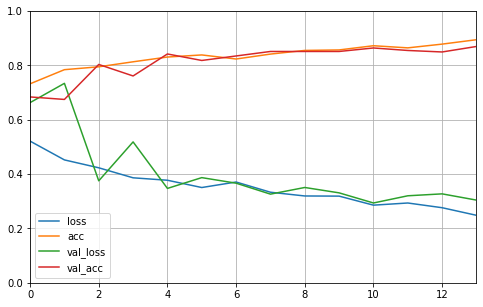

In [0]:
plot_hist(hist)

model.evaluate(test_images, test_labels)

## Train a ResNet

Try to train a ResNet without pre-trained weigths. 

In [0]:
class MyResnet(torch.nn.Module):
  def __init__(self, n_outputs=2, pretrained=True):
    super().__init__()
    self.resnet = torchvision.models.resnet18(pretrained=pretrained)
    if pretrained:
      for param in self.resnet.parameters():
        param.requires_grad=False
    self.resnet.fc = torch.nn.Linear(512, 2)

  def forward(self, x):
    x = self.resnet(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [0]:
model = Model(MyResnet(pretrained=False))

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.01),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_imgs, train_labels, validation_data=(val_imgs, val_labels), early_stopping=3)

training stopped at epoch 10
best model found at epoch 7 with val_loss 0.39135


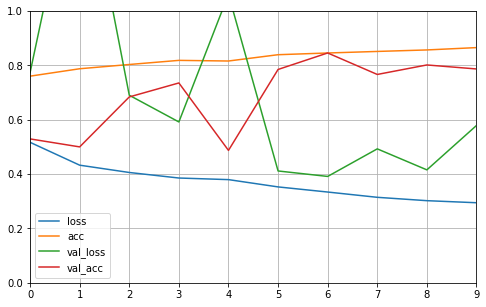

In [0]:
plot_hist(hist)

model.evaluate(test_images, test_labels)

Now perform transfer learning and see if you can get better results.

In [0]:
model = Model(MyResnet(pretrained=True))

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.01),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_imgs, train_labels, validation_data=(val_imgs, val_labels), early_stopping=3)

training stopped at epoch 12
best model found at epoch 9 with val_loss 0.33289


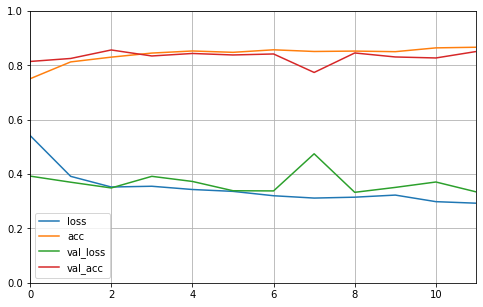

In [0]:
plot_hist(hist)

model.evaluate(test_images, test_labels)

In [0]:
model.net.unfreeze()

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.0001),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_imgs, train_labels, validation_data=(val_imgs, val_labels), early_stopping=3)

training stopped at epoch 9
best model found at epoch 6 with val_loss 0.32458


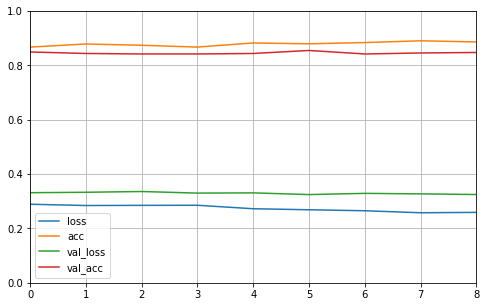

In [0]:
plot_hist(hist)

model.evaluate(test_images, test_labels)